In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ts_val_shuffle import FeaturesGenerator, Validator, MAPE, SMAPE, WAPE

c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\symfit\core\printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Для теста выбран датасет [Electric Production](https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=Electric_Production.csv)

In [2]:
df = pd.read_csv(r"data\Electric_Production.csv")

df = df.rename(columns={"IPG2211A2N": "value", "DATE": "date"})

df['date'] = pd.to_datetime(df['date'])
print(df.head())

        date    value
0 1985-01-01  72.5052
1 1985-02-01  70.6720
2 1985-03-01  62.4502
3 1985-04-01  57.4714
4 1985-05-01  55.3151


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB
None


In [4]:
train = df.iloc[:-48]
test = df.iloc[-60:] # 60, т.к. при генерации признаков 12 первых будут отброшены

## Пример с использованием Prophet из библиотеки Prophet

### Инициализируется валидатор

Для работы нужно выполнить 3 этапа:
1) Инициализировать исходный временный ряд;
2) Сгенерировать признаки, передав путь к JSON файлу;
3) Установить параметры инициализации и кросс-валидации, передав путь к JSON файлу;
4) Провести кросс-валидацию модели, задав метрику, название целевого признака и временного признака из исходных данных

In [5]:
val = Validator()

val.set_data(train)
val.set_generator(r"data\configs\features\config.json")
val.load_params(r"data\configs\params\validation_params_prophet.json")
val.validate()

16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
C:\University\kurs_3\semestr_2\практика\TSValShuffle\src\ts_val_shuffle\validate.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_only[feat] = test[feat].values
C:\University\kurs_3\semestr_2\практика\TSValShuffle\src\ts_val_shuffle\validate.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_only[feat] = test[feat].values
C:\University\kurs_3\semestr_2\практика\TSValShuffle\

In [6]:
print(pd.Series(val.metric_values))

0    0.037134
1    0.019633
2    0.017775
3    0.035913
4    0.024689
5    0.023620
6    0.026040
7    0.024939
8    0.040721
9    0.029134
dtype: float64


### Значения метрики WAPE в процессе кросс-валидации

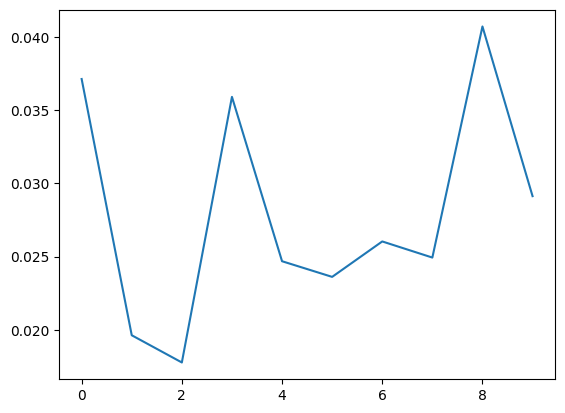

In [7]:
plt.plot(val.metric_values)
plt.show()

### Генерируем признаки для теста обученной модели

In [8]:
gen = FeaturesGenerator(r"data\configs\features\config.json")
test = gen.generate_features(test)

print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 349 to 396
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          48 non-null     datetime64[ns]
 1   value         48 non-null     float64       
 2   lag_6         48 non-null     float64       
 3   lag_12        48 non-null     float64       
 4   diff_lag_12   48 non-null     float64       
 5   diff_lag_6    48 non-null     float64       
 6   std_7         48 non-null     float64       
 7   mean_5_lag_5  48 non-null     float64       
 8   year          48 non-null     int32         
 9   month_cos     48 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int32(1)
memory usage: 3.9 KB
None


In [9]:
test = test.rename(columns={'date': 'ds', 'value': 'y'})
features = test.drop(columns=['y', 'ds']).columns.to_list()
freq = pd.infer_freq(test['ds'])
mfd_params = {
    # добавляем размер тестовой выборки из кросс-валидации из-за особенностей Prophet
    # make_future_dataframe генерирует будущее с последней точки, на которой остановилось обучение
    # т.к. в ходе кросс-валидации Prophet обучалась не до последнего элемента обучающей выборки, а до len(test) - val.split_handler.test_size,
    # то в будущем нужно добавить len(test) + val.split_handler.test_size точек, чтобы сгенерировать период из тестовой выборки
    "periods": len(test) + val.split_handler.test_size,
    "freq": freq,
    "include_history": False,
}
future = val.adapter.make_future_dataframe(mfd_params)[-len(test):] # генерируем датафрейм для предсказания
for feature in features:
    future[feature] = test[feature].values
print(future.tail())

           ds     lag_6    lag_12  diff_lag_12  diff_lag_6      std_7  \
73 2017-09-01  101.0396  102.7637      -4.1483     -2.4242   7.854984   
74 2017-10-01   88.3530   91.4867       2.1270      5.2607   8.200958   
75 2017-11-01   92.0805   92.8900       4.4459      5.2554   6.981896   
76 2017-12-01  102.1532  112.7694       1.9518     12.5680   7.468056   
77 2018-01-01  112.1538  114.8505      14.5543     17.2510  11.526408   

    mean_5_lag_5  year     month_cos  
73     102.78682  2017 -1.836970e-16  
74     103.09346  2017  5.000000e-01  
75     102.13000  2017  8.660254e-01  
76     102.64348  2017  1.000000e+00  
77     106.73820  2018  8.660254e-01  


### Предсказываем на выборке, которую модель ещё не видела

In [10]:
predict_params = {
    'df': future
}
pred = val.predict(predict_params)

print(pred.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          48 non-null     datetime64[ns]
 1   trend                       48 non-null     float64       
 2   yhat_lower                  48 non-null     float64       
 3   yhat_upper                  48 non-null     float64       
 4   trend_lower                 48 non-null     float64       
 5   trend_upper                 48 non-null     float64       
 6   multiplicative_terms        48 non-null     float64       
 7   multiplicative_terms_lower  48 non-null     float64       
 8   multiplicative_terms_upper  48 non-null     float64       
 9   yearly                      48 non-null     float64       
 10  yearly_lower                48 non-null     float64       
 11  yearly_upper                48 non-null     float64       
 

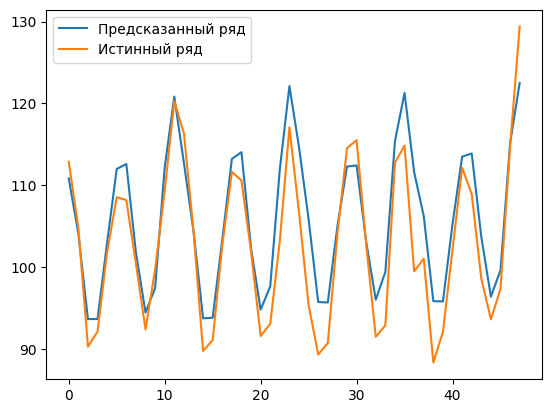

In [11]:
plt.plot(np.arange(0, 48), pred['prediction'], label='Предсказанный ряд')
plt.plot(np.arange(0, 48), test['y'], label='Истинный ряд')
plt.legend()
plt.show()

### Сравнение предсказанных и истинных данных

In [12]:
res = pd.DataFrame({
    'date': df['date'][-48:].values,
    'y_pred': pred['prediction'].values[-48:],
    'y_true': df['value'][-48:].values
})
print(res)

         date      y_pred    y_true
0  2014-02-01  110.841737  112.8811
1  2014-03-01  104.074264  104.7631
2  2014-04-01   93.654096   90.2867
3  2014-05-01   93.667429   92.1340
4  2014-06-01  103.028521  101.8780
5  2014-07-01  111.992066  108.5497
6  2014-08-01  112.609544  108.1940
7  2014-09-01  101.788093  100.4172
8  2014-10-01   94.457235   92.3837
9  2014-11-01   97.449978   99.7033
10 2014-12-01  112.185209  109.3477
11 2015-01-01  120.837048  120.2696
12 2015-02-01  112.747663  116.3788
13 2015-03-01  104.413268  104.4706
14 2015-04-01   93.746528   89.7461
15 2015-05-01   93.814649   91.0930
16 2015-06-01  103.332326  102.6495
17 2015-07-01  113.221498  111.6354
18 2015-08-01  114.046761  110.5925
19 2015-09-01  102.330629  101.9204
20 2015-10-01   94.806127   91.5959
21 2015-11-01   97.646371   93.0628
22 2015-12-01  111.972990  103.2203
23 2016-01-01  122.117595  117.0837
24 2016-02-01  114.662522  106.6688
25 2016-03-01  105.853472   95.3548
26 2016-04-01   95.735189   

### Значение метрики WAPE в данном случае

In [13]:
print(WAPE(res['y_true'], res['y_pred']))

0.03465082808398366
